# La idea en este cuadernillo es seguir avanzando con la importacion de tablas, corregirlas en algunos casos y ya despues poder generar vistas en postgreSQL y visualizaciones en PowerBi

## Pero antes de seguir, y dado que en los cuadernillos anteriores han surgido funciones que son utiles para interactuar con PostgreSQL desde Python, es que pense que podria ser util generar un archivo .py para luego llamarla a las funciones que consideremos relevantes (**y no tener que andar pegandolas cada vez)**

In [1]:
# ejemplo de como podemos usar las funciones que vayamos creando
from raaraya1 import SQL

usuario = SQL('curso_postgresql', 'Tester', '123456')

comando = 'select * from detergents'
usuario.mostrar_tabla(comando)


,0,1,2,3,4
0,DetergentID,Composition,PurityPercentage,Packaging,NominalPricePerLiter
1,Det001,C71,90,crysta500cc,766
2,Det002,C80,95,crysta1L,1989
3,Det003,C75,90,crystal40cc,1077
4,Det004,C79,95,crysta500cc,1140
5,Det005,C79,95,crystal40cc,1702


## Bien, de esta manera, cada vez que generemos una funcion que nos sea util, la podemos agregar al archivo SQL.py

### Retomando lo del cuadernillo anterior, me quedo pendiente colocar los datos en las tablas que correspondian. Y luego, me pasó ese error de que no aceptaba los datos por los tipos. Es por esa razon que estuve investigando y encontre que se pueden importar los datos csv mediante comandos de postgreSQL. Aunque al intentarlo, se me generaron un monton de errores

### De esta manera, en las siguientes lineas de codigo dejo la manera en como se deberian importar los datos, **pero ya digo que esto no me funciono a mi.**

In [6]:
# Entonces el comando para importar los datos del CSV a una tabla, posee la siguiente estructura
'''
COPY persons(first_name, last_name, dob, email)
FROM 'C:\sampledb\persons.csv'
DELIMITER ','
CSV HEADER;
'''

# creamos una tabla de prueba sin columnas
comando = 'create table prueba()'
usuario.ejecutar(comando)


## Sin embargo, y con el fin de abordar el problema desde otro angulo, será crear una funcion que acepte un dataframe y lo convierta en una tabla de postgreSQL.


In [3]:
# Lo primero que haré será borrar algunas de las tablas del cuadernillo anterior, para reacerlas
# en un formato mas flexible (despues tendremos toda la libertad de generar los cambios que sea pertinentes)

# partamos con una tabla (orders, por ejemplo)
import pandas as pd
nombre = 'orders'
ruta = 'https://raw.githubusercontent.com/raaraya1/University-Projects/main/Logistics/Datos/{}.csv'.format(nombre)
archivo = pd.read_csv(ruta, sep = ';')
df = pd.DataFrame(archivo)
df



,OrderID,ProductID,CustomerID,QuantityLiters
0,Order001,Det004,Customer001,9
1,Order002,Det002,Customer007,19
2,Order003,Det001,Customer003,19
3,Order004,Det002,Customer005,16
4,Order005,Det005,Customer002,2
5,Order006,Det003,Customer007,5
6,Order007,Det003,Customer002,1
7,Order008,Det003,Customer005,16
8,Order009,Det005,Customer007,9
9,Order0010,Det001,Customer002,13


In [18]:
# continuamos a borrar la tabla que habiamos generado en el cuadernillo anterior
from raaraya1 import SQL
usuario = SQL('curso_postgresql', 'Tester', '123456')

comdando = 'drop table IF EXISTS orders'
usuario.ejecutar(comando)

# lo que sigue es generar la tabla
columnas = list(df.columns)
arg = ''
for columna in columnas:
    arg += columna + ' varchar(50), ' 
arg = arg[:-2]
comando_base = 'create table {}({})'.format(nombre, arg)

# creamos la tabla
#usuario.ejecutar(comando_base)

# rellenemos la tabla

# cantidad de filas
num_filas = len(df)

# recorremos las filas del dataframe
for fila in range(num_filas):    
    comando_base = ''
    arg = ''
    
    # para rellenar un dato de una fila 
    for columna in columnas:
        arg += "'" + str(df[columna][fila]) + "', " 
    arg = arg[:-2]
    comando_base = 'insert into {} values({})'.format(nombre, arg)
    
    # ejecumatomos el comando
    usuario.ejecutar(comando_base)



In [20]:
# mostremos la tabla que acamabos de rellenar
comando = 'select * from orders'
df1 = usuario.mostrar_tabla(comando)
df1

,0,1,2,3
0,Order001,Det004,Customer001,9
1,Order002,Det002,Customer007,19
2,Order003,Det001,Customer003,19
3,Order004,Det002,Customer005,16
4,Order005,Det005,Customer002,2
5,Order006,Det003,Customer007,5
6,Order007,Det003,Customer002,1
7,Order008,Det003,Customer005,16
8,Order009,Det005,Customer007,9
9,Order0010,Det001,Customer002,13


### Listo, ahora genermos la funcion, guardemosla en nuestra clase y luego ocupemosla para importar el resto de las tablas


In [21]:
# creemos la funcion

def importar(nombre, df):
    # crear la tabla
    columnas = list(df.columns)
    arg = ''
    for columna in columnas:
        arg += columna + ' varchar(50), ' 
    arg = arg[:-2]
    comando_base = 'create table {}({})'.format(nombre, arg)
    usuario.ejecutar(comando_base)
    
    # rellenar la tabla
    num_filas = len(df)
    for fila in range(num_filas):    
        comando_base = ''
        arg = ''

        for columna in columnas:
            arg += "'" + str(df[columna][fila]) + "', " 
        arg = arg[:-2]
        comando_base = 'insert into {} values({})'.format(nombre, arg)

        usuario.ejecutar(comando_base)


In [24]:
# para probar que esta bien hecha la funcion voy a probar con otra tabla (ejemplo plants)

#comando = 'drop table plants'
#usuario.ejecutar(comando)

nombre = 'plants'
ruta = 'https://raw.githubusercontent.com/raaraya1/University-Projects/main/Logistics/Datos/{}.csv'.format(nombre)
archivo = pd.read_csv(ruta, sep = ';')
df = pd.DataFrame(archivo)

# importamos la tabla
importar(nombre, df)


In [29]:
# verificamos que se hayan importados los datos

comando = 'select * from plants'
df1 = usuario.mostrar_tabla(comando)
df1

,0,1,2,3,4,5
0,Plant001,6.795.458.019,3.095.143.418,760,324,362
1,Plant002,1.838.170.216,-2.386.330.645,906,76,201
2,Plant003,6.177.910.668,-2.966.737.339,691,382,345
3,Plant004,7.866.031.164,8.144.016.527,165,294,445
4,Plant005,5.305.397.278,-9.524.078.678,1000,292,499


## Con la funcion ya verificada, voy a proseguir a añadirla a la clase


In [4]:
# listo para ocupar nuestra nueva funcion para importar los dataframes
## se omite trabajar con la tabla routes_endtoend, ya que tiene una columnna con comnre conflictivo
import pandas as pd
from raaraya1 import SQL
usuario = SQL('curso_postgresql', 'Tester', '123456')

# ahora intentemos importar las tablas que restan 
# primero las voy a eliminar
'''
nombre_tablas = ['routes_available', 'routes_endtoend', 'routes_segment', 'variable_costs']
for nombre in nombre_tablas:
    comando_base = 'drop table {}'.format(nombre)
    usuario.ejecutar(comando_base)
'''

# ahora importamos las tablas
nombre_tablas = ['routes_available', 'routes_segment', 'variable_costs']
for nombre in nombre_tablas:
    ruta = 'https://raw.githubusercontent.com/raaraya1/University-Projects/main/Logistics/Datos/{}.csv'.format(nombre)
    archivo = pd.read_csv(ruta, sep = ';')
    df = pd.DataFrame(archivo)
    usuario.importar(nombre, df)
    


## **Lo que sigue es arreglar/modificar las tablas segun el tipo de datos**

In [10]:
# veamos un ejemplo de una tabla que se necesite arrglar los datos
comando = 'select * from orders'
df = usuario.mostrar_tabla(comando)
print(type(df[3][0]))

# este dato deberia figurar cono interger y no tipo str


<class 'str'>


In [11]:
# Intentemos cambiarlo

comando = 'alter table orders alter column quantityliters type int'
usuario.ejecutar(comando)

DatatypeMismatch: la columna «quantityliters» no puede convertirse automáticamente al tipo integer
HINT:  Puede ser necesario especificar «USING quantityliters::integer».


In [32]:
# de primeras no deja hacerlo asi, lo que intentare ahora sera:
# 1) guardar los valores de la ultima columna
# 2) eliminar la ultima columna
# 3) agregar nueva columna con el tipo correcto
# 4) agregar un columna serial como indice
# 5) rellerar la columna con los valores guardados previamente (estos tambien los tengo que transformar)
# 6) borrar el indice

# 1) guardar los valores de la ultima colomna
'''
comando = 'select quantityliters from orders'
df = usuario.mostrar_tabla(comando)
columna_guardada = list(df[0][:])
columna_guardada = [int(valor) for valor in columna_guardada]
print(columna_guardada)
'''

# 2) eliminar la ultima columna

'''comando = 'alter table orders drop column quantityliters'
usuario.ejecutar(comando)
'''

# 3) agregar nueva columna con el tipo correcto

'''comando = 'alter table orders add column quantityliters int'
usuario.ejecutar(comando)
'''

# 4) agregar un columna serial como indice

'''comando = 'alter table orders add column indice serial'
usuario.ejecutar(comando)
'''
# 5) rellerar la columna con los valores guardados previamente

'''for ind, valor in enumerate(columna_guardada):
    comando = 'update orders set quantityliters = {} where indice = {}'.format(valor, (ind+1))
    usuario.ejecutar(comando)
'''

# 6) borramos el indice

'''comando = 'alter table orders drop column indice'
usuario.ejecutar(comando)'''

## **Como tuve exito haciendo los cambios de esta manera, lo siguiente que voy a hacer es dejar los pasos anteriores como una fucnion, agregarla a nuestra clase y despues corregir el resto de las tablas**

In [8]:
import pandas as pd
import psycopg2
from raaraya1 import SQL

usuario = SQL('curso_postgresql', 'Tester', '123456')

def column_type_int(nombre_tabla, nombre_columna):
    nombre_tabla = str(nombre_tabla)
    nombre_columna = str(nombre_columna)
    
    # 1) guardar los valores de la ultima colomna
    comando_base = 'select {} from {}'.format(nombre_columna, nombre_tabla)
    df = usuario.mostrar_tabla(comando_base)
    columna_guardada = list(df[0][:])
    columna_guardada = [int(valor) for valor in columna_guardada]
    
    # 2) eliminar la ultima columna
    comando = 'alter table {} drop column {}'.format(nombre_tabla, nombre_columna)
    usuario.ejecutar(comando)
    
    # 3) agregar nueva columna con el tipo correcto
    comando = 'alter table {} add column {} int'.format(nombre_tabla, nombre_columna)
    usuario.ejecutar(comando)
    
    # 4) agregar un columna serial como indice
    comando = 'alter table {} add column indice serial'.format(nombre_tabla)
    usuario.ejecutar(comando)
    
    # 5) rellerar la columna con los valores guardados previamente
    for ind, valor in enumerate(columna_guardada):
        comando = 'update {} set {} = {} where indice = {}'.format(nombre_tabla, nombre_columna, valor, (ind+1))
        usuario.ejecutar(comando)
        
    # 6) borramos el indice
    comando = 'alter table {} drop column indice'.format(nombre_tabla)
    usuario.ejecutar(comando)
    


In [4]:
# probemos que la funcion anterior funciona intentando arreglar la columna de otra tabla

comando = 'select * from routes_available'
df = usuario.mostrar_tabla(comando)
df

,0,1,2,3,4
0,Route001,Plant001,DC001,Customer001,0
1,Route002,Plant002,DC002,Customer001,1
2,Route003,Plant001,DC004,Customer001,0
3,Route004,Plant001,DC004,Customer001,1
4,Route005,Plant002,DC002,Customer001,0
...,...,...,...,...,...
115,Route00116,Plant001,nan,Customer007,0
116,Route00117,Plant002,nan,Customer007,1
117,Route00118,Plant004,DC001,Customer002,0
118,Route00119,Plant001,DC001,Customer003,0


In [12]:
# observando la tabla anterior, podemos notar que la unica columna que podria necesitar cambiar el tipo 
# de dato a entero, es la ultima
print(type(df[4][0]))

# cambiemoslo con la funcion que generamos recien
tabla = 'routes_available'
columna = 'RailUse'
column_type_int(tabla, columna)

comando = 'select * from routes_available'
df = usuario.mostrar_tabla(comando)

print(type(df[4][0]))



<class 'numpy.int64'>
<class 'numpy.int64'>


## Por ultimo, voy a dejar guardada esta funcion en el archivo .py y el siguiente cuadernillo lo voy a dedicar unicamente a arreglar el resto de las tablas

## Adicionales (Errores)

1) Insuficiencia de privilegios para un usuario
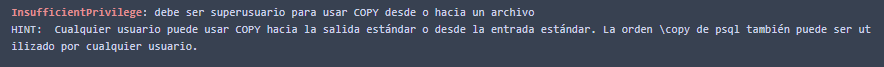

Se soluciona haciendo click derecho en el usuario, abriendo sus propiedades y cambiando sus privilegios.
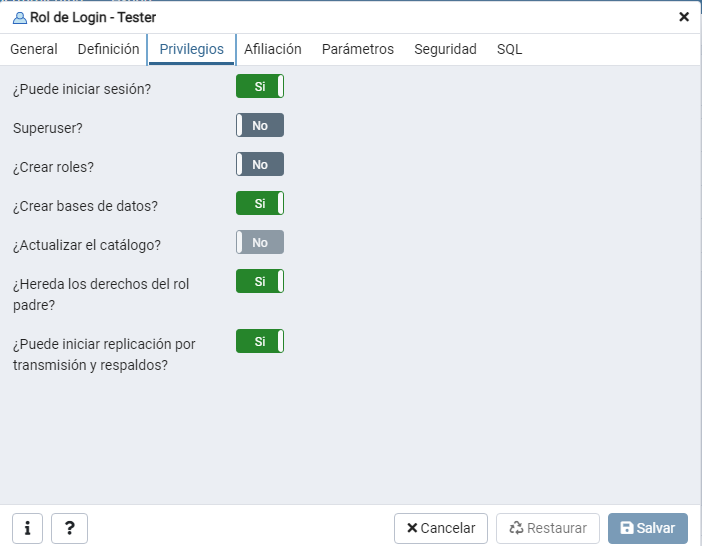

2) Este error, no lo logre solucionar y por eso toma otra ruta para importar los archivo.
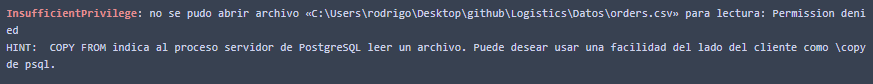

El error se generaba cuando intentataba importar un archivo csv desde la consola de comando, sin embargo, con la importandola desde el administrador no me generó ningun problema.